# Detection of sleep, wake and movement from physiological parameters


Database source: 
    
    Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/content/101/23/e215.full]; 2000 (June 13).


In [1]:
from __future__ import division
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as ss
import seaborn as sns
from scipy.ndimage import convolve1d
import itertools
import sleep_utils as su

# import psycopg2
import datetime  
import time 
import wfdb
import glob

from biosppy.signals import ecg

%matplotlib inline
sns.set()
pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

## Load a file from database

In [2]:
data_dir = '../data/MIT-BIH_Polysomnographic_Database/'

co2_sig = []
ppg_sig = []

filenames = []

sleep_data_sigs = {}
sleep_data_fields = {}

data_keys = []
for fname in glob.iglob(data_dir + '/*.dat'):#, recursive=True):
    # filename manipulation
    base = os.path.basename(fname)
    key = os.path.splitext(base)[0]
    data_keys.append(key)
    
    # load data
    sig, fields=wfdb.rdsamp(data_dir+key)
    sleep_data_sigs[key] = sig
    sleep_data_fields[key] = fields

In [3]:
ann_index = {}
ann_range = {}
ann_labels = {}

set_stages = set()
for key in data_keys:
    annotation = wfdb.rdann(data_dir + key, 'st')
    ann_index[key] = annotation[0]
    ann_range[key] = list(zip(ann_index[key], ann_index[key] +7500))
    ann_labels[key] = annotation[5]
    set_stages = set(list(set_stages) + [x.rsplit(' ')[0] for x in ann_labels[key]])


In [4]:
resp_data_set = {}
ecg_data_set = {}
time_data_set = {}
annot_data_set = {}

fs = 250
dec_prec = len(str(1/fs).split('.')[1])

for key in data_keys:
    
    resp_data_set[key] = (sleep_data_sigs[key])[ann_range[key][0][0]-1:, (sleep_data_fields[key])['signame'].index('Resp')]
    ecg_data_set[key] = (sleep_data_sigs[key])[ann_range[key][0][0]-1:, (sleep_data_fields[key])['signame'].index('ECG')]
    time_data_set[key] = np.arange(0, len(resp_data_set[key]))/fs

    # Note: Only the first character of the annotation was taken as label
    # Example: 1, 2, 3, 4, R, W, M
    stages = [x.rsplit(' ')[0][0] for x in ann_labels[key]]
    stages_list = list(itertools.chain.from_iterable(itertools.repeat(x, 7500) for x in stages))
    annot_data_set[key] = stages_list
    
    if abs(len(resp_data_set[key]) - len(stages_list)) >0 :
        print(key)

#### *Annotations*

Stages:
   * W: subject is awake
   * 1: sleep stage 1
   * 2: sleep stage 2
   * 3: sleep stage 3
   * 4: sleep stage 4
   * R: REM sleep
   
Other descriptions:
   * H: Hypopnea
   * HA: Hypopnea with arousal
   * OA: Obstructive apnea
   * X: Obstructive apnea with arousal
   * CA: Central apnea
   * CAA: Central apnea with arousal
   * L: Leg movements
   * LA: Leg movements with arousal
   * A: Unspecified arousal
   * MT: Movement time

## Get Features

### I. Previous sleep stage

Note: Get features for every window of data

In [5]:
win_size = 7500 # length of window
win_dur = win_size/fs # duration of window, unit: seconds
win_step = 1 # duration by which the window slides, unit: seconds
win_int = win_step*fs # length by which the window slides

In [6]:
feature_prev_stage = {}
feature_time_index = {}
for key in data_keys:
    print("Computing for "+ key + "...")

    prev_stage = [np.nan] + annot_data_set[key][1:]
    feature_windows = su.array_rolling_window(np.array(prev_stage), win_size)
    time_windows = su.array_rolling_window(time_data_set[key], win_size)

    selected_index = np.arange(0, len(feature_windows), win_int)

    features = feature_windows[selected_index, -1]
    times = time_windows[selected_index, -1]
    feature_prev_stage[key] = {'_feat' : features, '_time': times}
    

Computing for slp01a...
Computing for slp01b...
Computing for slp02a...
Computing for slp02b...
Computing for slp03...
Computing for slp04...
Computing for slp32...
Computing for slp41...
Computing for slp45...
Computing for slp48...
Computing for slp60...
Computing for slp67x...


In [7]:
feature_labels = {} ### Labels: N, R, W, M

label_count = 0
for key in data_keys:
    print("Computing for "+ key + "...")

    window_stages = su.array_rolling_window(np.array(annot_data_set[key]), win_size)
    time_windows = su.array_rolling_window(time_data_set[key], win_size)    
    selected_index = np.arange(0, len(window_stages), win_int)

    labels = window_stages[selected_index, -1]
    
    for x in ['1', '2', '3', '4']:
        labels[np.where(labels == x)] = 'N' 
    feature_labels[key] = {'label' : labels, '_time': times}
    
    label_count+= len(labels)
    print(label_count)

Computing for slp01a...
7171
Computing for slp01b...
17942
Computing for slp02a...
28713
Computing for slp02b...
36784
Computing for slp03...
58355
Computing for slp04...
79926
Computing for slp32...
99097
Computing for slp41...
122468
Computing for slp45...
145239
Computing for slp48...
168010
Computing for slp60...
189281
Computing for slp67x...
193872


### II. Respiratory rate
Get respiration rate and related features (e.g. first derivative and second derivative of respiration rate). 


In [8]:
# Respiratory frequency range 
min_normrange = 4/60 # unit: cycles per second
max_normrange = 65/60 # unit: cycles per second

feature_resp_rate = {}
feature_resp_rate_fd = {}
feature_resp_rate_sd = {}

for key in data_keys:
    print("Computing for "+ key + "...")
    resp_sig = resp_data_set[key]
    fft_resp = np.fft.fft(resp_sig)
    fft_freqs = np.fft.fftfreq(len(resp_sig), 1/fs)
    
    # Remove frequencies which are outside the expected range
    fft_resp[abs(fft_freqs) < min_normrange] = 0
    fft_resp[abs(fft_freqs) > max_normrange] = 0
    
    resp_filt_sig = np.real(np.fft.ifft(fft_resp))

    # Divide into windows
    resp_windows = su.array_rolling_window(np.array(resp_filt_sig), win_size)
    time_windows = su.array_rolling_window(time_data_set[key], win_size)

    selected_index = np.arange(0, len(resp_windows), win_int)
    times = time_windows[selected_index, -1]
    
    resp_data = pd.DataFrame({'_time': list(time_windows[selected_index, :]), 'resp': list(resp_windows[selected_index, :])})
    resp_data['power_spectrum'] = resp_data.resp.apply(lambda x: ss.periodogram(x, fs=fs))
    
    # Compute respiration rate
    resp_data['resp_rate'] = resp_data.power_spectrum.apply(lambda x: (x[0])[np.argmax(x[1])]*60)
    resp_data['window_time'] = resp_data['_time'].apply(lambda x: x[-1])
    
    # Compute first derivative of respiration rate
    resp_data['resp_rate_fd'] = resp_data.resp_rate.diff()/(resp_data.window_time.diff() )
    
    # Compute second derivative of respiration rate
    resp_data['resp_rate_sd'] = resp_data.resp_rate_fd.diff()/(resp_data.window_time.diff() )

    feature_resp_rate[key] = {'_feat' : resp_data.resp_rate.values, '_time': times}
    feature_resp_rate_fd[key] = {'_feat' : resp_data.resp_rate_fd.values, '_time': times}
    feature_resp_rate_sd[key] = {'_feat' : resp_data.resp_rate_sd.values, '_time': times}

    

Computing for slp01a...
Computing for slp01b...
Computing for slp02a...
Computing for slp02b...
Computing for slp03...
Computing for slp04...
Computing for slp32...
Computing for slp41...
Computing for slp45...
Computing for slp48...
Computing for slp60...
Computing for slp67x...


### III. Heart rate
Get heart rate and related features (e.g. heart rate variability, first derivative and second derivative of heart rate). 

In [9]:
feature_heart_rate = {}
feature_heart_rate_fd = {}
feature_heart_rate_sd = {}
feature_heart_rate_var = {}

for key in data_keys:
    print("Computing for "+ key + "...")
    
    ecg_sig = ecg_data_set[key]
    # Divide into windows
    ecg_windows = su.array_rolling_window(np.array(ecg_sig), win_size)
    time_windows = su.array_rolling_window(time_data_set[key], win_size)    
    
    selected_index = np.arange(0, len(ecg_windows), win_int)
    times = time_windows[selected_index, -1]
    
    ecg_data = pd.DataFrame({'_time': list(time_windows[selected_index, :]), 'ecg_sig': list(ecg_windows[selected_index, :])})
    
    # Get time corresponding to R peaks
    ecg_data['r_peaks'] = ecg_data.ecg_sig.apply(lambda x: ecg.hamilton_segmenter(x)['rpeaks'])
    ecg_data['r_time'] = ecg_data.apply(lambda x: list(x._time[x.r_peaks]), axis = 1)
    
    # Compute heart rate
    ecg_data['heart_rate'] = ecg_data.r_time.apply(lambda x: su.heart_rate(np.array(x))*60)
    ecg_data['window_time'] = ecg_data['_time'].apply(lambda x: x[-1])
    
    # Compute first derivative of heart rate
    ecg_data['heart_rate_fd'] = ecg_data.heart_rate.diff()/(ecg_data.window_time.diff() )
    
    # Compute second derivative of heart rate
    ecg_data['heart_rate_sd'] = ecg_data.heart_rate_fd.diff()/(ecg_data.window_time.diff() )
    
    # Compute heart rate variability
    ecg_data['heart_rate_var'] = ecg_data.r_time.apply(lambda x: su.heart_rate_var(np.array(x))*1000)
    
    feature_heart_rate[key] = {'_feat' : ecg_data.heart_rate.values, '_time': times}
    feature_heart_rate_fd[key] = {'_feat' : ecg_data.heart_rate_fd.values, '_time': times}
    feature_heart_rate_sd[key] = {'_feat' : ecg_data.heart_rate_sd.values, '_time': times}
    feature_heart_rate_var[key] = {'_feat' : ecg_data.heart_rate_var.values, '_time': times}

    

Computing for slp01a...
Computing for slp01b...
Computing for slp02a...
Computing for slp02b...
Computing for slp03...


/Users/eventura/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/eventura/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


Computing for slp04...
Computing for slp32...
Computing for slp41...
Computing for slp45...
Computing for slp48...
Computing for slp60...
Computing for slp67x...


## Visualize features 

In [10]:
sample_key = data_keys[0]

In [11]:
stage_list = ['N', 'R', 'W', 'M']
colors = ['dodgerblue', 'palegreen', 'darkorange',  'yellow']
stage_color_dict = dict(zip(stage_list, colors))
print(stage_color_dict)

{'R': 'palegreen', 'M': 'yellow', 'W': 'darkorange', 'N': 'dodgerblue'}


In [12]:
class_features = [feature_prev_stage[sample_key]['_feat'], 
                  feature_resp_rate[sample_key]['_feat'], 
                  feature_resp_rate_fd[sample_key]['_feat'],
                  feature_resp_rate_sd[sample_key]['_feat'], 
                  feature_heart_rate[sample_key]['_feat'],
                  feature_heart_rate_fd[sample_key]['_feat'],
                  feature_heart_rate_sd[sample_key]['_feat'], 
                  feature_heart_rate_var[sample_key]['_feat']]

In [13]:
## Replace symbols for stages with numerical values
class_features[0][np.where(class_features[0] == '1')] = 1
class_features[0][np.where(class_features[0] == '2')] = 2
class_features[0][np.where(class_features[0] == '3')] = 3
class_features[0][np.where(class_features[0] == '4')] = 4
class_features[0][np.where(class_features[0] == 'R')] = 5
class_features[0][np.where(class_features[0] == 'W')] = 6
class_features[0][np.where(class_features[0] == 'M')] = 7

## Convert to float
class_features[0] = np.array(class_features[0], dtype = float)

In [14]:
# Get labels

xtime = feature_labels[sample_key]['_time']
stages = feature_labels[sample_key]['label']


In [15]:
stages[np.where(stages == 'N')] = 1
stages[np.where(stages == 'R')] = 2
stages[np.where(stages == 'W')] = 3
stages[np.where(stages == 'M')] = 4

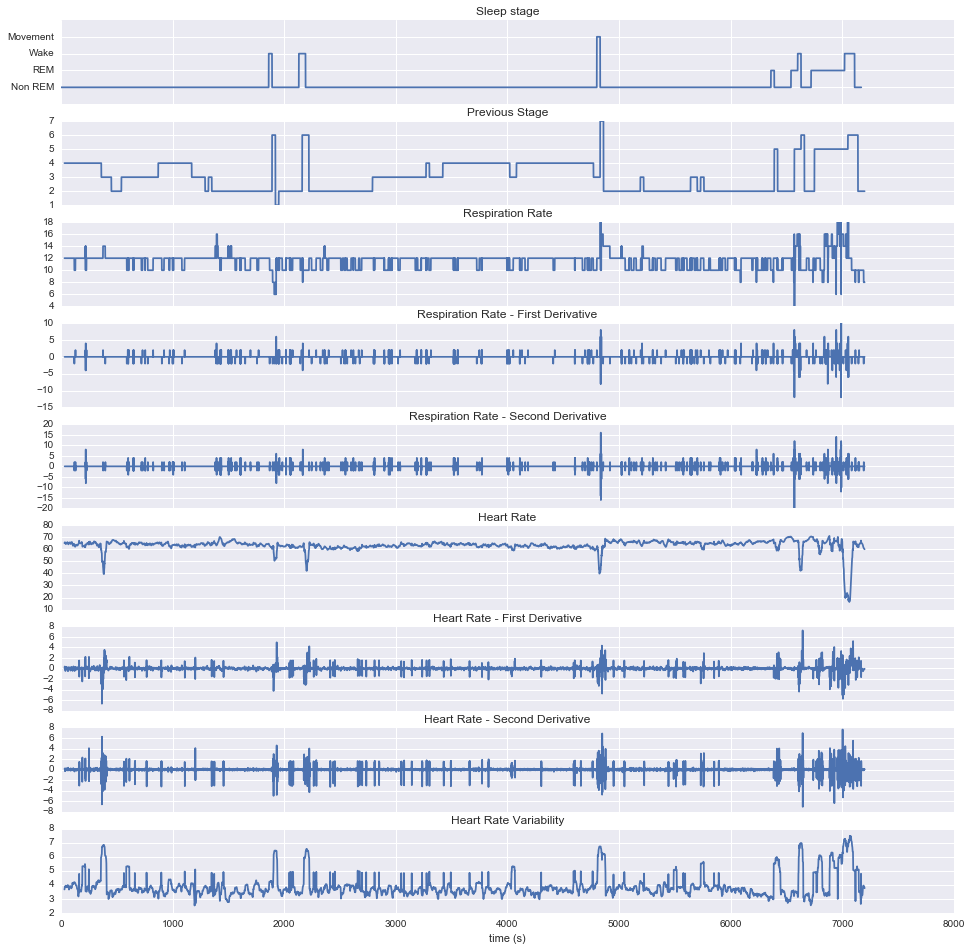

In [16]:
f, axarr = plt.subplots(len(class_features)+1, sharex=True)
f.set_figheight(16)
f.set_figwidth(16)

axarr[0].plot(stages)
plt.sca(axarr[0])
plt.yticks([ 1, 2, 3, 4], ['Non REM', 'REM', 'Wake', 'Movement'])
plt.ylim([0, 5])

axarr[1].plot(feature_prev_stage[sample_key]['_time'], class_features[0])
axarr[2].plot(feature_prev_stage[sample_key]['_time'], class_features[1])
axarr[3].plot(feature_prev_stage[sample_key]['_time'], class_features[2])
axarr[4].plot(feature_prev_stage[sample_key]['_time'], class_features[3])
axarr[5].plot(feature_prev_stage[sample_key]['_time'], class_features[4])
axarr[6].plot(feature_prev_stage[sample_key]['_time'], class_features[5])
axarr[7].plot(feature_prev_stage[sample_key]['_time'], class_features[6])
axarr[8].plot(feature_prev_stage[sample_key]['_time'], np.log(class_features[7]))
axarr[0].set_title('Sleep stage')
axarr[1].set_title('Previous Stage')
axarr[2].set_title('Respiration Rate')
axarr[3].set_title('Respiration Rate - First Derivative')
axarr[4].set_title('Respiration Rate - Second Derivative')
axarr[5].set_title('Heart Rate')
axarr[6].set_title('Heart Rate - First Derivative')
axarr[7].set_title('Heart Rate - Second Derivative')
axarr[8].set_title('Heart Rate Variability')
plt.sca(axarr[8])
plt.xlabel("time (s)")



In [17]:
# f, axarr = plt.subplots(len(class_features)+1, sharex=True)
# f.set_figheight(16)
# f.set_figwidth(16)

# axarr[0].plot(stages)
# axarr[0].set_ylim([0, 1])

# for x in range(len(stages)):
#     axarr[0].axvspan(xtime[x], xtime[x] + win_step, ymin=0, ymax=1, alpha = 0.7, 
#                 color = stage_color_dict[list(stages[x])[0]]) 

# axarr[1].plot(feature_prev_stage[sample_key]['_time'], class_features[0])
# axarr[2].plot(feature_prev_stage[sample_key]['_time'], class_features[1])
# axarr[3].plot(feature_prev_stage[sample_key]['_time'], class_features[2])
# axarr[4].plot(feature_prev_stage[sample_key]['_time'], class_features[3])
# axarr[5].plot(feature_prev_stage[sample_key]['_time'], class_features[4])
# axarr[6].plot(feature_prev_stage[sample_key]['_time'], class_features[5])
# axarr[7].plot(feature_prev_stage[sample_key]['_time'], class_features[6])
# axarr[8].plot(feature_prev_stage[sample_key]['_time'], class_features[7])
# axarr[0].set_title('Sleep stage: Blue - NREM, Green - REM, Orange, Yellow - Movement')
# axarr[1].set_title('Previous Stage')
# axarr[2].set_title('Respiration Rate')
# axarr[3].set_title('Respiration Rate - First Derivative')
# axarr[4].set_title('Respiration Rate - Second Derivative')
# axarr[5].set_title('Heart Rate')
# axarr[6].set_title('Heart Rate - First Derivative')
# axarr[7].set_title('Heart Rate - Second Derivative')
# axarr[8].set_title('Heart Rate Variability')

# plt.xlabel("time (s)")



## Compile features 
Combine features computed across all patients

In [18]:
merge_features0 = []
merge_features1 = []
merge_features2 = []
merge_features3 = []
merge_features4 = []
merge_features5 = []
merge_features6 = []
merge_features7 = []
merge_labels = []

for key in data_keys:
    merge_features0 += list(feature_prev_stage[key]['_time'])
    merge_features1 += list(feature_resp_rate[key]['_feat'])
    merge_features2 += list(feature_resp_rate_fd[key]['_feat'])
    merge_features3 += list(feature_resp_rate_sd[key]['_feat'])
    merge_features4 += list(feature_heart_rate[key]['_feat'])
    merge_features5 += list(feature_heart_rate_fd[key]['_feat'])
    merge_features6 += list(feature_heart_rate_sd[key]['_feat'])
    merge_features7 += list(feature_heart_rate_var[key]['_feat'])
    
    merge_labels += list(feature_labels[key]['label'])

In [19]:
sleep_features = np.concatenate((np.reshape(merge_features0, [len(merge_features0), 1]),
                                 np.reshape(merge_features1, [len(merge_features1), 1]),
                                 np.reshape(merge_features2, [len(merge_features2), 1]),
                                 np.reshape(merge_features3, [len(merge_features3), 1]),
                                 np.reshape(merge_features4, [len(merge_features4), 1]),
                                 np.reshape(merge_features5, [len(merge_features5), 1]),
                                 np.reshape(merge_features6, [len(merge_features6), 1]),
                                 np.reshape(merge_features7, [len(merge_features7), 1])), axis = 1)

In [20]:
sleep_data = sleep_features[np.isfinite(sleep_features).all(axis=1)]
sleep_labels = np.reshape(merge_labels, [len(merge_labels), 1])[np.isfinite(sleep_features).all(axis=1)]

In [21]:
len(sleep_labels), len(sleep_data)

(193845, 193845)

## Divide into training and test set

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [24]:
sleep_data_scaled = StandardScaler().fit_transform(sleep_data)

In [25]:
train_set, test_set, train_label, test_label = train_test_split(sleep_data_scaled, sleep_labels, test_size=0.33, random_state=42)

In [26]:
names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "AdaBoost",
         "Naive Bayes", "QDA", "Linear SVM", "RBF SVM",]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(), 
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1)]

In [27]:
for i in [0, 1, 2, 3]:
    print('Training ' + names[i])
    clf = classifiers[i]
    clf.fit(train_set, np.ndarray.flatten(train_label))
    prediction = clf.predict(test_set)
    print(names[i], accuracy_score(test_label, prediction))
    

Training Nearest Neighbors
('Nearest Neighbors', 0.77828323093998653)
Training Decision Tree
('Decision Tree', 0.71250136785005236)
Training Random Forest
('Random Forest', 0.71916084353358656)
Training AdaBoost
('AdaBoost', 0.64123247197861466)


### Add more Respiration-based features

In [64]:
feature_mean_resp = {}
feature_median_resp = {}
feature_max_resp = {}
feature_hist_resp = {}

nbins = 10

for key in data_keys:
    print("Computing for "+ key + "...")
    resp_sig = resp_data_set[key]
    fft_resp = np.fft.fft(resp_sig)
    fft_freqs = np.fft.fftfreq(len(resp_sig), 1/fs)
    
    # Remove frequencies which are outside the expected range
    fft_resp[abs(fft_freqs) < min_normrange] = 0
    fft_resp[abs(fft_freqs) > max_normrange] = 0
    
    resp_filt_sig = np.real(np.fft.ifft(fft_resp))

    # Divide into windows
    resp_windows = su.array_rolling_window(np.array(resp_filt_sig), win_size)
    time_windows = su.array_rolling_window(time_data_set[key], win_size)

    selected_index = np.arange(0, len(resp_windows), win_int)
    resp_windows = resp_windows[selected_index, :]
    times = time_windows[selected_index, -1]
    
    hist_windows = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins)[0], 1, resp_windows)
    mean_windows = np.nanmean(resp_windows, axis = 1)
    median_windows = np.nanmedian(resp_windows, axis = 1)
    max_windows = np.nanmax(resp_windows, axis = 1)
    
    feature_hist_resp[key] = {'_feat' : hist_windows, '_time': times}
    feature_mean_resp[key] = {'_feat' : mean_windows, '_time': times}
    feature_median_resp[key] = {'_feat' : median_windows, '_time': times}
    feature_max_resp[key] = {'_feat' : max_windows, '_time': times}


Computing for slp01a...
Computing for slp01b...
Computing for slp02a...
Computing for slp02b...
Computing for slp03...
Computing for slp04...
Computing for slp32...
Computing for slp41...
Computing for slp45...
Computing for slp48...
Computing for slp60...
Computing for slp67x...


### Add more ECG-based features

In [71]:
feature_mean_heart = {}
feature_median_heart = {}
feature_max_heart = {}
feature_hist_heart = {}

for key in data_keys:
    print("Computing for "+ key + "...")
    
    # Divide into windows
    ecg_windows = su.array_rolling_window(ecg_data_set[key], win_size)
    time_windows = su.array_rolling_window(time_data_set[key], win_size)

    selected_index = np.arange(0, len(ecg_windows), win_int)
    ecg_windows = ecg_windows[selected_index, :]
    times = time_windows[selected_index, -1]
    
    hist_windows = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins)[0], 1, ecg_windows)
    mean_windows = np.nanmean(ecg_windows, axis = 1)
    median_windows = np.nanmedian(ecg_windows, axis = 1)
    max_windows = np.nanmax(ecg_windows, axis = 1)
    
    feature_hist_heart[key] = {'_feat' : hist_windows, '_time': times}
    feature_mean_heart[key] = {'_feat' : mean_windows, '_time': times}
    feature_median_heart[key] = {'_feat' : median_windows, '_time': times}
    feature_max_heart[key] = {'_feat' : max_windows, '_time': times}


Computing for slp01a...
Computing for slp01b...
Computing for slp02a...
Computing for slp02b...
Computing for slp03...
Computing for slp04...
Computing for slp32...
Computing for slp41...
Computing for slp45...
Computing for slp48...
Computing for slp60...
Computing for slp67x...


In [75]:
merge_features8 = []
merge_features9 = []
merge_features10 = []
merge_features11 = []
merge_features12 = []
merge_features13 = []
merge_features14 = np.zeros([1, nbins])
merge_features15 = np.zeros([1, nbins])

for key in data_keys:
    merge_features8 += list(feature_max_heart[key]['_time'])
    merge_features9 += list(feature_max_resp[key]['_feat'])
    merge_features10 += list(feature_mean_heart[key]['_feat'])
    merge_features11 += list(feature_mean_resp[key]['_feat'])
    merge_features12 += list(feature_median_heart[key]['_feat'])
    merge_features13 += list(feature_median_resp[key]['_feat'])
    
    merge_features14 = np.concatenate((merge_features14, feature_hist_heart[key]['_feat']), axis = 0)
    merge_features15 = np.concatenate((merge_features15, feature_hist_resp[key]['_feat']), axis = 0)

In [81]:
sleep_features2 = np.concatenate((sleep_features,
                                 np.reshape(merge_features8, [len(merge_features1), 1]),
                                 np.reshape(merge_features9, [len(merge_features2), 1]),
                                 np.reshape(merge_features10, [len(merge_features3), 1]),
                                 np.reshape(merge_features11, [len(merge_features4), 1]),
                                 np.reshape(merge_features12, [len(merge_features5), 1]),
                                 np.reshape(merge_features13, [len(merge_features6), 1]),
                                 merge_features14[1:, :], merge_features15[1:, :]), axis = 1)

sleep_data2 = sleep_features2[np.isfinite(sleep_features2).all(axis=1)]
sleep_labels2 = np.reshape(merge_labels, [len(merge_labels), 1])[np.isfinite(sleep_features2).all(axis=1)]

### Classification with added features

In [83]:
sleep_data_scaled2 = StandardScaler().fit_transform(sleep_data2)
train_set, test_set, train_label, test_label = train_test_split(sleep_data_scaled2, sleep_labels2, test_size=0.33, random_state=42)

In [84]:
for i in [0, 1, 2, 3]:
    print('Training ' + names[i])
    clf = classifiers[i]
    clf.fit(train_set, np.ndarray.flatten(train_label))
    prediction = clf.predict(test_set)
    print(names[i], accuracy_score(test_label, prediction))
    

Training Nearest Neighbors
('Nearest Neighbors', 0.93617220841345028)
Training Decision Tree
('Decision Tree', 0.72736794384780123)
Training Random Forest
('Random Forest', 0.7832856539886508)
Training AdaBoost
('AdaBoost', 0.23816223483249699)
